>학번 : 2017250024

>이름 : 오재영


## 기본 설정

In [35]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 과제 1
조기 종료를 사용한 배치 경사 하강법으로 로지스틱 회귀를 구현하라. 단, 사이킷런을 전혀 사용하지 않아야 한다.

## 데이터 준비

붓꽃 데이터셋을 불러오기 위해서 사이킷런에서 제공하는 붓꽃 데이터셋을 불러왔다.

* (오직 데이터셋을 불러오기 위해서 사용한다. 로지스틱 회귀를 구현하는 과정에서는 사용하지 않을 것이다.) 

In [36]:
from sklearn import datasets
iris = datasets.load_iris()

꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에 사용되는 데이터셋을 지정한다.

In [37]:
X = iris["data"][:, 3:]                   # 꽃잎 너비 (petal width) 특성만 사용
y = (iris["target"] == 2).astype(np.int)  # 0이면 음성 (버지니카(Virginica) 품종이 아닐 때 ), 1이면 양성 (버지니카(Virginica) 품종일 때)

결과를 일정하게 유지하기 위해 랜덤 시드를 지정한다.

In [38]:
np.random.seed(42)

## 데이터셋 분할

데이터셋을 훈련, 검증, 테스트 용도로 6대 2대 2의 비율로 무작위로 분할한다.

In [39]:
test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
total_size = len(X)                            # 전체 데이터셋 크기

test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%

`np.random.permutation()` 함수를 이용하여 인덱스를 무작위로 섞는다.

In [40]:
rnd_indices = np.random.permutation(total_size)

인덱스가 무작위로 섞였기 때문에 무작위로 분할하는 효과를 얻는다. 

* 섞인 인덱스를 이용하여 지정된 6:2:2의 비율로 훈련, 검증, 테스트 세트로 분할하는 방법 사용

In [41]:
X_train = X[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

X_test = X[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

## 로지스틱 회귀 구현

* 로지스틱 회귀 : 파라미터와 특성값들의 선형합에 시그모이드 함수를 적용하여 양성 확률을 추정하는 이진 분류 모델

### 시그모이드 함수 정의

* 시그모이드 함수 : 어떤 숫자가 들어와도 0과 1 사이의 값으로 변환해주는 함수.

* (로지스틱 회귀를 구현하는데 있어서 필수적이다.)

> 1 / 1 + e^−x (e(e=2.718281...)는 자연 상수)

In [42]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

<function matplotlib.pyplot.show>

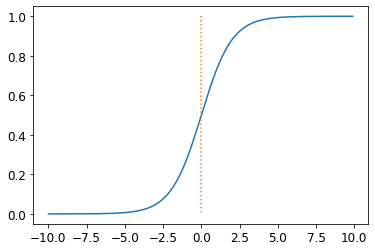

In [43]:
# 간략한 시그모이드 함수를 보여주는 그래프
ara = np.arange(-10, 10, 0.1)
sig = sigmoid(ara)
plt.plot(ara, sig)
plt.plot([0,0],[1.0,0.0], ':') # 가운데 점선을 추가해주는 코드
plt.show

### 그 외 도움을 주는 함수들 정의


* 가중치 W와 바이어스(편향) b를 0으로 초기화 하는 함수

In [44]:
def init_weights(dim):
    W = np.zeros((dim, 1))
    b = 0
    return W, b

* 예측한 것의 정확도를 측정해주는 함수
 * `y_pred`: 예측할 데이터
 * `y_ture`: 예측할 데이터에 대한 실제 데이터 

In [45]:
def accuracy(y_pred, y_true):
    y_pred, y_true = np.squeeze(y_pred), np.squeeze(y_true) # 1차원 배열로 차원 축소
    assert y_pred.shape == y_true.shape
    y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred])  # i가 0.5보다 크면 1, 0.5보다 작으면 0의 값을 갖는 배열 생성 
    return 1 - np.sum(np.abs(y_pred - y_true))/len(y_true) # 측정한 정확도 리턴

* 훈련 된 가중치가 주어지면 전진 과정을 거치는 함수

In [46]:
def predict(X, W, b):
    Z = np.dot(W.T, X) + b
    Y_hat = sigmoid(Z)
    return Y_hat

## 경사하강법 활용 훈련

### 경사 하강법 훈련 함수

* `learning_rate` = 학습률
* `iterations` = 에포크 수
* `verbose` = 손실 출력 여부
* `print_every_n` = n 에포크 마다 출력

In [47]:
def train(X, Y, learning_rate=0.01, iterations=1000, verbose=False, print_every_n=10):
    """
    X: n x m 배열 (n: 특성 m: 샘플)
    y: 1 x m 배열
    """
    
    epsilon = 1e-7         # log 값이 항상 계산되도록 더해지는 작은 실수
    best_loss = np.infty   # 최소 손실값 기억 변수
    n = X.shape[0]
    m = X.shape[1]
    W, b = init_weights(n)
    assert W.shape == (n, 1)
    assert Y.shape == (1, m)
    

    # 경사 하강법
    losses = []
    for i in range(iterations):
        Z = np.dot(W.T, X) + b
        Y_hat = sigmoid(Z)
        assert Y_hat.shape == (1, m)

        loss = -1/m * np.sum((Y*np.log(Y_hat+epsilon) + (1-Y)*np.log(1 - Y_hat+epsilon)))  # 손실 함수
        losses.append(loss)
        
        # 그레이디언트 계산
        dW = np.dot(X, (Y_hat - Y).T)/m
        db = np.mean(Y_hat - Y)

        # 업데이트
        W -= learning_rate*dW
        b -= learning_rate*db
        
        # 500 에포크마다 검증 세트에 대한 손실 출력
        if verbose and i % print_every_n == 0:
          print(f'iterations {i}, loss {loss}') 

        # 에포크마다 최소 손실값 업데이트
        if loss < best_loss:
          best_loss = loss
        else:
          print(f'iterations {i - 1}, loss {best_loss}')        # 종료되지 이전 에포크의 손실값 출력
          print(f'iterations {i}, loss {loss}', "조기 종료")
          break
            
    return {'W': W, 'b': b, 'loss': losses}

* 훈련 요구 사항에 맞추기 위한 변수를 정의한다.

In [48]:
X = X_train.T
Y = y_train.reshape(1, -1)

print('X shape', X.shape)
print('Y shape', Y.shape)

X shape (1, 90)
Y shape (1, 90)


### 훈련 실행

학습률 0.1을 주고 에포크 수 5001로 하여 실행한다.

In [49]:
model = train(X, Y, learning_rate=0.1, iterations=5001, verbose=True, print_every_n=500)

iterations 0, loss 0.6931469805599654
iterations 500, loss 0.26702816372709853
iterations 1000, loss 0.21215619722772855
iterations 1500, loss 0.1862887083246962
iterations 2000, loss 0.17011031233167387
iterations 2500, loss 0.15867453431444137
iterations 3000, loss 0.1500182963478993
iterations 3500, loss 0.14317117915350602
iterations 4000, loss 0.13758522633369552
iterations 4500, loss 0.13292215863134893
iterations 5000, loss 0.128959341427769


### 정확도 측정

In [50]:
W = model['W']
b = model['b']

y_pred = predict(X_valid.T, W, b)
y_true = y_valid.reshape(1, -1)

# 정확도 측정
acc = accuracy(y_pred, y_true)
print('정확도: {:.2f}%'.format(acc*100)) ## 퍼센트로 소수점 둘째 자리 까지 출력

정확도: 93.33%


정확도가 93.33% 이다.

학습된 파라미터는 다음과 같다.

In [51]:
print('W :', W, 'b :', b)

W : [[5.77154623]] b : -9.701423811214548


조기종료가 잘 구현된 것을 확인할 수 있다.

## 규제 추가

* `learning_rate` = 학습률
* `iterations` = 에포크 수
* `alpha` = 규제 강도
* `verbose` = 손실 출력 여부
* `print_every_n` = n 에포크 마다 출력

In [53]:
def train_reg(X, Y, learning_rate=0.01, iterations=1000, alpha=0.1, verbose=False, print_every_n=10):
    """
    X: n x m 배열 (n: 특성 m: 샘플)
    y: 1 x m 배열
    """
    alpha = 0.1            # 규제 하이퍼파라미터
    epsilon = 1e-7         # log 값이 항상 계산되도록 더해지는 작은 실수
    best_loss = np.infty   # 최소 손실값 기억 변수
    n = X.shape[0]
    m = X.shape[1]
    W, b = init_weights(n)
    assert W.shape == (n, 1)
    assert Y.shape == (1, m)
    

    # 경사 하강법
    losses = []
    for i in range(iterations):
        Z = np.dot(W.T, X) + b
        Y_hat = sigmoid(Z)
        assert Y_hat.shape == (1, m)

        xentloss = -1/m * np.sum((Y*np.log(Y_hat+epsilon) + (1-Y)*np.log(1 - Y_hat+epsilon)))  # 손실 함수
        l2_reg = 1/2 * np.sum(np.square(W))
        loss = xentloss + alpha * l2_reg        # l2 규제가 추가된 손실
        losses.append(loss)
        
        # 그레이디언트 계산
        dW = np.dot(X, (Y_hat - Y).T)/m
        db = np.mean(Y_hat - Y)
        l2_loss_gradients = alpha * W   # l2 규제 그레이디언트
        # 업데이트
        W -= learning_rate*dW + l2_loss_gradients
        b -= learning_rate*db
        
        # 500 에포크마다 검증 세트에 대한 손실 출력
        if verbose and i % print_every_n == 0:
          print(f'iterations {i}, loss {loss}') 

        # 에포크마다 최소 손실값 업데이트
        if loss < best_loss:
          best_loss = loss
        else:
          print(f'iterations {i - 1}, loss {best_loss}')        # 종료되지 이전 에포크의 손실값 출력
          print(f'iterations {i}, loss {loss}', "조기 종료")
          break
            
    return {'W': W, 'b': b, 'loss': losses}

### 훈련 실행

In [54]:
model = train_reg(X, Y, learning_rate=0.1, iterations=5001, verbose=True, print_every_n=500)

iterations 0, loss 0.6931469805599654
iterations 500, loss 0.5431155899320959
iterations 1000, loss 0.5431004435025538
iterations 1500, loss 0.5431004381120348
iterations 1790, loss 0.5431004381101332
iterations 1791, loss 0.5431004381101332 조기 종료


조기종료도 잘 구현된것을 확인할 수 있다.

# 과제 3

## A

* 사진을 낮과 밤으로 분류하는 로지스틱 회귀 모델을 구현하라.


### 사진 다운로드

미리 모아둔 사진 100개를 깃허브에서 다운받아서 사용할 것이다.

파일을 다운로드하기 전에 앞서 언급한 디렉토리의 경로를 지정한다.

In [55]:
datapath_1 = os.path.join("images", "sky", "day", "")
datapath_2 = os.path.join("images", "sky", "night", "")

저의 깃허브에 파일을 저장해 두었고 깃허브에서 파일을 불러와서 다운로드하도록 하였다. 파일은 총 100개이고 `day` 레포지토리에는 낮 사진 `night` 레포지토리에는 밤 사진이 있다.

In [56]:
import urllib.request
DOWNLOAD_ROOT = "https://github.com/Vest1ge/Images/"
os.makedirs(datapath_1, exist_ok=True)
os.makedirs(datapath_2, exist_ok=True)
for i in range(1, 46):
    print("낮 사진 다운로드:", str(i))
    url_1 = DOWNLOAD_ROOT + 'blob/main/sky/day/' + str(i) + '.png'
    urllib.request.urlretrieve(url_1, datapath_1 + str(i) + '.png')
    i += 1
for i in range(1, 56):
    print("밤 사진 다운로드:", str(i))
    url_2 = DOWNLOAD_ROOT + 'blob/main/sky/night/' + str(i) + '.png'
    urllib.request.urlretrieve(url_2, datapath_2 + str(i) + '.png')
    i += 1

낮 사진 다운로드: 1
낮 사진 다운로드: 2
낮 사진 다운로드: 3
낮 사진 다운로드: 4
낮 사진 다운로드: 5
낮 사진 다운로드: 6
낮 사진 다운로드: 7
낮 사진 다운로드: 8
낮 사진 다운로드: 9
낮 사진 다운로드: 10
낮 사진 다운로드: 11
낮 사진 다운로드: 12
낮 사진 다운로드: 13
낮 사진 다운로드: 14
낮 사진 다운로드: 15
낮 사진 다운로드: 16
낮 사진 다운로드: 17
낮 사진 다운로드: 18
낮 사진 다운로드: 19
낮 사진 다운로드: 20
낮 사진 다운로드: 21
낮 사진 다운로드: 22
낮 사진 다운로드: 23
낮 사진 다운로드: 24
낮 사진 다운로드: 25
낮 사진 다운로드: 26
낮 사진 다운로드: 27
낮 사진 다운로드: 28
낮 사진 다운로드: 29
낮 사진 다운로드: 30
낮 사진 다운로드: 31
낮 사진 다운로드: 32
낮 사진 다운로드: 33
낮 사진 다운로드: 34
낮 사진 다운로드: 35
낮 사진 다운로드: 36
낮 사진 다운로드: 37
낮 사진 다운로드: 38
낮 사진 다운로드: 39
낮 사진 다운로드: 40
낮 사진 다운로드: 41
낮 사진 다운로드: 42
낮 사진 다운로드: 43
낮 사진 다운로드: 44
낮 사진 다운로드: 45
밤 사진 다운로드: 1
밤 사진 다운로드: 2
밤 사진 다운로드: 3
밤 사진 다운로드: 4
밤 사진 다운로드: 5
밤 사진 다운로드: 6
밤 사진 다운로드: 7
밤 사진 다운로드: 8
밤 사진 다운로드: 9
밤 사진 다운로드: 10
밤 사진 다운로드: 11
밤 사진 다운로드: 12
밤 사진 다운로드: 13
밤 사진 다운로드: 14
밤 사진 다운로드: 15
밤 사진 다운로드: 16
밤 사진 다운로드: 17
밤 사진 다운로드: 18
밤 사진 다운로드: 19
밤 사진 다운로드: 20
밤 사진 다운로드: 21
밤 사진 다운로드: 22
밤 사진 다운로드: 23
밤 사진 다운로드: 24
밤 사진 다운로드: 25
밤 사진 다운로드: 26
밤 사진 다운로드: 27
밤 사진 다운로드:

파일이 다운로드 되었다. 이제 이미지 파일들을 데이터셋으로 만들어야 한다.

### 데이터셋 만들기

## B 

* 사진을 낮과 밤, 실내와 실외로 분류하는 다중 레이블 분류 모델을 두 개의 로지스틱 회귀 모델을 이용하여 구현하라

## C
* 과제 1에서 구현한 자신의 알고리즘과 사이킷런에서 제공하는 LogisticRegression 모델의 성능을 비교하라.